In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
import streamlit as st
import mlflow
import dvc.api
from google.cloud import storage

import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


2024-05-14 12:05:44.267630: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
global storage_client
global bucket_name
storage_client = storage.Client()
bucket_name = "mlops-car-detection"

def list_blobs(bucket_name):
    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)
    
    # for blob in blobs:
    #     print(blob.name)
        
    blob_names = [blob.name for blob in blobs if blob.name.endswith('.jpg')]
    return blob_names
    # blob_list_names = [blob.name for blob in blobs if blob.name.endswith(".jpg")]

In [3]:
def display_random_image(bucket_name):
    blob_names = list_blobs(bucket_name)
    if not blob_names:
        print("No .jpg files found in the bucket.")
        return
    
    # Randomly select a blob name
    selected_blob_name = random.choice(blob_names)
    # print("Selected Blob:", selected_blob_name)

    # Download the selected blob
    blob = storage_client.bucket(bucket_name).get_blob(selected_blob_name)
    if blob is None:
        print("Failed to retrieve blob.")
        return

    # Download the blob's content
    blob_content = blob.download_as_bytes()

    # Decode the image content
    nparr = np.frombuffer(blob_content, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Display the image
    # cv2.imshow("Random Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image

# Call the function to display a random image from the specified bucket
display_random_image(bucket_name)

array([[[145, 119,  89],
        [145, 119,  89],
        [145, 119,  89],
        ...,
        [126, 118, 111],
        [ 56,  49,  46],
        [ 55,  50,  47]],

       [[145, 119,  89],
        [145, 119,  89],
        [145, 119,  89],
        ...,
        [ 71,  63,  56],
        [ 74,  67,  64],
        [ 82,  77,  74]],

       [[145, 119,  89],
        [145, 119,  89],
        [145, 119,  89],
        ...,
        [ 56,  48,  41],
        [ 98,  91,  88],
        [114, 109, 106]],

       ...,

       [[ 86,  98, 102],
        [ 87,  99, 103],
        [ 88, 100, 104],
        ...,
        [ 69,  83,  95],
        [ 67,  79,  91],
        [ 52,  66,  78]],

       [[ 77,  86,  89],
        [ 80,  89,  92],
        [ 81,  93,  95],
        ...,
        [ 88, 100, 112],
        [ 90,  99, 112],
        [ 91, 103, 115]],

       [[ 47,  55,  55],
        [ 51,  59,  59],
        [ 52,  62,  62],
        ...,
        [ 82,  91, 104],
        [ 73,  82,  95],
        [ 84,  93, 106]]

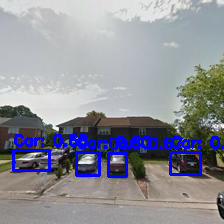

Speed: 0.7ms preprocess, 785.5ms inference, 0.1ms postprocess per image at shape torch.Size([1, 3, 224, 224])


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
import time
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the SSD model
ssd_model = torchvision.models.detection.ssd300_vgg16(pretrained=True, progress=False)

# Assuming display_random_image() retrieves an image
image = display_random_image(bucket_name)

# Preprocess the image
start = time.time()
transform = transforms.Compose([transforms.ToTensor()])
input_image = transform(image).unsqueeze(0)  
preprocess_time = time.time() - start

# Set the model to evaluation mode
ssd_model.eval()

# Forward pass
start = time.time()
with torch.no_grad():
    prediction = ssd_model(input_image)
inference_time = time.time() - start

# Convert the image to a numpy array
start = time.time()
plot = np.array(image)
postprocess_time = time.time() - start

# Post-process the output to get bounding boxes, labels, and scores for objects with probability >= 0.8
car_boxes = []
car_labels = []
car_scores = []

for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if label == 3 and score >= 0.5:  # Label 3 corresponds to 'car' in COCO dataset
        car_boxes.append(box.cpu().numpy())
        car_labels.append(label.cpu().numpy())
        car_scores.append(score.cpu().numpy())

# Draw bounding boxes on the image for cars only
for box, label, score in zip(car_boxes, car_labels, car_scores):
    box = box.astype(int)
    color = (255, 0, 0)  # Red color
    cv2.rectangle(plot, (box[0], box[1]), (box[2], box[3]), color, 2)
    cv2.putText(plot, f"Car: {score:.2f}", (box[0], box[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Convert image from BGR to RGB
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

# Display the image
display(Image.fromarray(plot))

# Display processing times
print(f"Speed: {preprocess_time * 1000:.1f}ms preprocess, {inference_time * 1000:.1f}ms inference, {postprocess_time * 1000:.1f}ms postprocess per image at shape {input_image.shape}")
